# Image AM-RNN using signed integers

In [1]:
import os, shutil, sys, warnings, datetime
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as plt, patches as patches
from keras import backend as K, preprocessing as kpre, \
                             datasets as kdat, models as kmod, \
                             layers as klay, optimizers as kopt, \
                             utils as kutil, callbacks as kcall, \
                             initializers as kinit, activations as kact, \
                             regularizers as kreg, applications as kapp, \
                             constraints as kcon, engine as keng
from keras.legacy import interfaces
import tensorflow as tf
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from jupyterthemes import jtplot

Using TensorFlow backend.


In [2]:
jtplot.reset()
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

### Runs summary:

1. 20190922 22:52:47
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - CuDNNGRU 4096
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$
        
2. 20190922 23:13:18
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - GRU 4096 + tanh-tanh
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$

3. 20190922 23:24:50
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - FC-RNN 4096 + tanh
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$
        
4. 20190922 23:33:22
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - LSTM 4096 + tanh-tanh
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$
        
5. 20190922 23:40:05
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - LSTM 4096 + tanh-sigmoid
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$
        
6. 20190923 22:26:23
    * 2 inputs from DR2-ImageNet, signed `int8`
    * Architecture:
        1. Reshape $64 \times 64 \times 1 \rightarrow 64 \times 64$
        - SRU 4096 + tanh-sigmoid
        - FC 4096 + tanh
        - Reshape $64 \times 64 \rightarrow 64 \times 64 \times 1$
        
7. 20191006 23:42:06
    * 1 input from DR2-ImageNet, signed `float32`
    * Architecture:
        1. Reshape $49 \times 49 \times 1 \rightarrow 49 \times 49$
        - SRU 4096 + tanh-sigmoid
        - FC 4096 + tanh
        - Reshape $49 \times 49 \rightarrow 49 \times 49 \times 1$

## Initialization cells

In [3]:
class AdaBound(kopt.Optimizer):
    def __init__(self,
                 lr=0.001,
                 final_lr=0.1,
                 beta_1=0.9,
                 beta_2=0.999,
                 gamma=1e-3,
                 epsilon=None,
                 decay=0.,
                 amsbound=False,
                 weight_decay=0.,
                 **kwargs):
        """
        Keras port [1] of AdaBound Optimizer for PyTorch [2], from the paper 
        Adaptive Gradient Methods with Dynamic Bound of Learning Rate [3].
        
        AdaBound optimizer.
        
        Default parameters follow those provided in the original paper.
        # Arguments
            lr: float >= 0. Learning rate.
            final_lr: float >= 0. Final learning rate.
            beta_1: float, 0 < beta < 1. Generally close to 1.
            beta_2: float, 0 < beta < 1. Generally close to 1.
            gamma: float >= 0. Convergence speed of the bound function.
            epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
            decay: float >= 0. Learning rate decay over each update.
            weight_decay: Weight decay weight.
            amsbound: boolean. Whether to apply the AMSBound variant of this
                algorithm.
        
        [1] Majumdar, S. keras-adabound, 2019. https://github.com/titu1994/keras-adabound.
        [2] Luo, L. AdaBound, 2019. https://github.com/Luolc/AdaBound.
        [3] Luo, L., Yuanhao, X., Yan, L., and Xu, S. Adaptive gradient methods with dynamic
            bound of learning rate. International Conference on LEarning Representations, 2019.
            https://openreview.net/forum?id=Bkg3g2R9FX.
        """
        super(AdaBound, self).__init__(**kwargs)
        
        if not 0. < gamma <= 1.:
            raise ValueError('Invalid `gamma` parameter. Must lie in [0, 1] range.')
            
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            
        self.final_lr = final_lr
        self.gamma = gamma
        
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)
        
        
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates
    
    
    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class StopOnValue(kcall.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(kcall.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        
    
    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)
            
        if current < self.value:
            if self.verbose > 0:
                print('Epoch %05d: early stopping THR' % epoch)
            self.model.stop_training = True

    
def l2loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.nn.l2_loss(y_pred - y_true)

def l1loss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.losses.absolute_difference(y_true, y_pred)

def tvloss(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

def psnr(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def tv(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        y_true = tf.image.resize(y_true, tf.shape(y_pred)[1:3])
    return tf.reduce_sum(tf.image.total_variation(y_true - y_pred))

In [4]:
def _time_distributed_dense(x, w, b=None, dropout=None,
                            input_dim=None, output_dim=None,
                            timesteps=None, training=None):
    """Apply `y . w + b` for every temporal slice y of x.
    # Arguments
        x: input tensor.
        w: weight matrix.
        b: optional bias vector.
        dropout: wether to apply dropout (same dropout mask
            for every temporal slice of the input).
        input_dim: integer; optional dimensionality of the input.
        output_dim: integer; optional dimensionality of the output.
        timesteps: integer; optional number of timesteps.
        training: training phase tensor or boolean.
    # Returns
        Output tensor.
    """
    if not input_dim:
        input_dim = K.shape(x)[2]
    if not timesteps:
        timesteps = K.shape(x)[1]
    if not output_dim:
        output_dim = K.int_shape(w)[1]

    if dropout is not None and 0. < dropout < 1.:
        # apply the same dropout pattern at every timestep
        ones = K.ones_like(K.reshape(x[:, 0, :], (-1, input_dim)))
        dropout_matrix = K.dropout(ones, dropout)
        expanded_dropout_matrix = K.repeat(dropout_matrix, timesteps)
        x = K.in_train_phase(x * expanded_dropout_matrix, x, training=training)

    # collapse time dimension and batch dimension together
    x = K.reshape(x, (-1, input_dim))
    x = K.dot(x, w)
    if b is not None:
        x = K.bias_add(x, b)
    # reshape to 3D tensor
    if K.backend() == 'tensorflow':
        x = K.reshape(x, K.stack([-1, timesteps, output_dim]))
        x.set_shape([None, None, output_dim])
    else:
        x = K.reshape(x, (-1, timesteps, output_dim))
    return x


class SRU(klay.Recurrent):
    """
    Keras implementation [1] of Simple Recurrent Unit [2]
    
    References:
    [1] S. Majumdar. keras-SRU. (2017).
    [2] T. Lei and Y. Zhang. Training RNNs as fast as CNNs. arXiv:1709.02755v2. (2017).
    """
    
    @interfaces.legacy_recurrent_support
    def __init__(self,
                 units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 project_input=False,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=True,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.0,
                 recurrent_dropout=0.0,
                 implementation=2,
                 **kwargs):
        super(SRU, self).__init__(**kwargs)
        self.units = units
        self.activation = kact.get(activation)
        self.recurrent_activation = kact.get(recurrent_activation)
        self.use_bias = use_bias
        self.project_input = project_input

        self.kernel_initializer = kinit.get(kernel_initializer)
        self.recurrent_initializer = kinit.get(recurrent_initializer)
        self.bias_initializer = kinit.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = kreg.get(kernel_regularizer)
        self.recurrent_regularizer = kreg.get(recurrent_regularizer)
        self.bias_regularizer = kreg.get(bias_regularizer)
        self.activity_regularizer = kreg.get(activity_regularizer)

        self.kernel_constraint = kcon.get(kernel_constraint)
        self.recurrent_constraint = kcon.get(recurrent_constraint)
        self.bias_constraint = kcon.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_spec = [keng.InputSpec(shape=(None, self.units)),
                           keng.InputSpec(shape=(None, self.units))]

        self.implementation = implementation
        
    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec[0] = keng.InputSpec(shape=(batch_size, None, self.input_dim))  # (timesteps, batchsize, inputdim)

        self.states = [None, None]
        if self.stateful:
            self.reset_states()

        if self.project_input:
            self.kernel_dim = 4
        elif self.input_dim != self.units:
            self.kernel_dim = 4
        else:
            self.kernel_dim = 3

        self.kernel = self.add_weight(shape=(self.input_dim, self.units * self.kernel_dim),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(shape, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        kinit.Ones()((self.units,), *args, **kwargs),
                    ])
            else:
                bias_initializer = self.bias_initializer

            self.bias = self.add_weight(shape=(self.units * 2,),
                                        name='bias',
                                        initializer=bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        self.kernel_w = self.kernel[:, :self.units]
        self.kernel_f = self.kernel[:, self.units: self.units * 2]
        self.kernel_r = self.kernel[:, self.units * 2: self.units * 3]

        if self.kernel_dim == 4:
            self.kernel_p = self.kernel[:, self.units * 3: self.units * 4]
        else:
            self.kernel_p = None

        if self.use_bias:
            self.bias_f = self.bias[:self.units]
            self.bias_r = self.bias[self.units: self.units * 2]
        else:
            self.bias_f = None
            self.bias_r = None
        self.built = True
        
    def preprocess_input(self, inputs, training=None):
        if self.implementation == 0:
            input_shape = K.int_shape(inputs)
            input_dim = input_shape[2]
            timesteps = input_shape[1]

            x_w = _time_distributed_dense(inputs, self.kernel_w, None,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)
            x_f = _time_distributed_dense(inputs, self.kernel_f, self.bias_f,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)
            x_r = _time_distributed_dense(inputs, self.kernel_r, self.bias_r,
                                          self.dropout, input_dim, self.units,
                                          timesteps, training=training)

            x_f = self.recurrent_activation(x_f)
            x_r = self.recurrent_activation(x_r)

            if self.kernel_dim == 4:
                x_p = _time_distributed_dense(inputs, self.kernel_p, None,
                                              self.dropout, input_dim, self.units,
                                              timesteps, training=training)

                return K.concatenate([x_w, x_f, x_r, x_p], axis=2)
            else:
                return K.concatenate([x_w, x_f, x_r], axis=2)
        else:
            return inputs
        
    def get_constants(self, inputs, training=None):
        constants = []
        if self.implementation != 0 and 0 < self.dropout < 1:
            input_shape = K.int_shape(inputs)  # (timesteps, batchsize, inputdim)
            input_dim = input_shape[-1]
            ones = K.ones_like(K.reshape(inputs[:, 0, 0], (-1, 1)))
            ones = K.tile(ones, (1, int(input_dim)))

            def dropped_inputs():
                return K.dropout(ones, self.dropout)

            dp_mask = [K.in_train_phase(dropped_inputs,
                                        ones,
                                        training=training) for _ in range(3)]
            constants.append(dp_mask)
        else:
            constants.append([K.cast_to_floatx(1.) for _ in range(3)])

        if 0 < self.recurrent_dropout < 1:
            ones = K.ones_like(K.reshape(inputs[:, 0, 0], (-1, 1)))
            ones = K.tile(ones, (1, self.units * self.kernel_dim))

            def dropped_inputs():
                return K.dropout(ones, self.recurrent_dropout)
            rec_dp_mask = [K.in_train_phase(dropped_inputs,
                                            ones,
                                            training=training) for _ in range(self.kernel_dim)]
            constants.append(rec_dp_mask)
        else:
            constants.append([K.cast_to_floatx(1.) for _ in range(self.kernel_dim)])
        return constants
    
    def step(self, inputs, states):
        h_tm1 = states[0]  # not used
        c_tm1 = states[1]
        dp_mask = states[2]
        rec_dp_mask = states[3]

        if self.implementation == 2:
            z = K.dot(inputs * dp_mask[0], self.kernel)
            z = z * rec_dp_mask[0]

            z0 = z[:, :self.units]

            if self.use_bias:
                z_bias = K.bias_add(z[:, self.units: self.units * 3], self.bias)
                z_bias = self.recurrent_activation(z_bias)
                z1 = z_bias[:, :self.units]
                z2 = z_bias[:, self.units: 2 * self.units]
            else:
                z1 = z[:, self.units: 2 * self.units]
                z2 = z[:, 2 * self.units: 3 * self.units]

            if self.kernel_dim == 4:
                z3 = z[:, 3 * self.units: 4 * self.units]
            else:
                z3 = None

            f = z1
            r = z2

            c = f * c_tm1 + (1 - f) * z0
            if self.kernel_dim == 4:
                h = r * self.activation(c) + (1 - r) * z3
            else:
                h = r * self.activation(c) + (1 - r) * inputs
        else:
            if self.implementation == 0:
                x_w = inputs[:, :self.units]
                x_f = inputs[:, self.units: 2 * self.units]
                x_r = inputs[:, 2 * self.units: 3 * self.units]
                if self.kernel_dim == 4:
                    x_w_x = inputs[:, 3 * self.units: 4 * self.units]
                else:
                    x_w_x = None
            elif self.implementation == 1:
                x_w = K.dot(inputs * dp_mask[0], self.kernel_w)
                x_f = K.dot(inputs * dp_mask[1], self.kernel_f) + self.bias_f
                x_r = K.dot(inputs * dp_mask[2], self.kernel_r) + self.bias_r

                x_f = self.recurrent_activation(x_f)
                x_r = self.recurrent_activation(x_r)

                if self.kernel_dim == 4:
                    x_w_x = K.dot(inputs * dp_mask[0], self.kernel_p)
                else:
                    x_w_x = None
            else:
                raise ValueError('Unknown `implementation` mode.')

            w = x_w * rec_dp_mask[0]
            f = x_f
            r = x_r

            c = f * c_tm1 + (1 - f) * w
            if self.kernel_dim == 4:
                h = r * self.activation(c) + (1 - r) * x_w_x
            else:
                h = r * self.activation(c) + (1 - r) * inputs

        if 0 < self.dropout + self.recurrent_dropout:
            h._uses_learning_phase = True

        return h, [h, c]
    
    def get_config(self):
        config = {'units': self.units,
                  'activation': kact.serialize(self.activation),
                  'recurrent_activation': kact.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': kinit.serialize(self.kernel_initializer),
                  'recurrent_initializer': kinit.serialize(self.recurrent_initializer),
                  'bias_initializer': kinit.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': kreg.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': kreg.serialize(self.recurrent_regularizer),
                  'bias_regularizer': kreg.serialize(self.bias_regularizer),
                  'activity_regularizer': kreg.serialize(self.activity_regularizer),
                  'kernel_constraint': kcon.serialize(self.kernel_constraint),
                  'recurrent_constraint': kcon.serialize(self.recurrent_constraint),
                  'bias_constraint': kcon.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(SRU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Train data import & pre-processing

In [5]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST/'
img_w = 49
img_h = 49
img_ch = 1

In [6]:
files = os.listdir(traindir)
for f in range(len(files)):
    img = cv.imread(traindir + files[f], 0)
    img = cv.resize(img, (img_w, img_h))
    img = cv.equalizeHist(img)
    if f == 0:
        x_train = np.zeros((len(files), img_h, img_w))
    x_train[f] = img

In [7]:
cap = 2
x_train0 = x_train[:cap]
x_train0 = x_train0.astype('float32')
x_train0 -= x_train0.max()/2
x_train0 /= x_train0.max()
x_train0 = np.expand_dims(x_train0, -1)
x_train0 = np.tile(x_train0.T, 64//cap).T

## Model setup

In [8]:
sessiondir = '{}/'.format(datetime.datetime.now().strftime('%Y%m%d'))
os.makedirs(sessiondir, exist_ok=True)
batch_size = len(x_train0)
epochs = int(1e6)

In [9]:
amrnn = kmod.Sequential()
amrnn.add(klay.Reshape(input_shape=(img_h, img_w, img_ch),
                       target_shape=(img_h, img_w),
                       name='reshape1'))
amrnn.add(SRU(units=img_h*img_w,
              activation='tanh',
              recurrent_activation='sigmoid',
              name='rnn-sru1'))
amrnn.add(klay.Dense(units=img_h*img_w,
                     activation='tanh',
                     name='fc1'))
amrnn.add(klay.Reshape(target_shape=(img_h, img_w, img_ch),
                       name='reshape2'))

amrnn.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape1 (Reshape)           (None, 49, 49)            0         
_________________________________________________________________
rnn-sru1 (SRU)               (None, 2401)              475398    
_________________________________________________________________
fc1 (Dense)                  (None, 2401)              5767202   
_________________________________________________________________
reshape2 (Reshape)           (None, 49, 49, 1)         0         
Total params: 6,242,600
Trainable params: 6,242,600
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpoint = kcall.ModelCheckpoint('AMRNN_best_weights.h5',
                                   save_best_only=True,
                                   monitor='loss',
                                   mode='min')
csvlogger = kcall.CSVLogger('AMRNN_training.log', 
                            separator=',', 
                            append=False)
tblogdir = log_dir='./.tb_logs/%s/' \
           %(datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
os.makedirs(tblogdir)
tblog = kcall.TensorBoard(tblogdir,
                          histogram_freq=0,
                          write_graph=True,
                          embeddings_freq=0,
                          update_freq='epoch',
                          write_images=True)
stopval = StopOnValue(monitor='loss',
                      value=0.10)

In [11]:
amrnn.compile(loss=l2loss,
              optimizer=AdaBound(lr=1e-3,
                                 final_lr=5e-4),
              metrics=[psnr, ssim])
# amrnn.load_weights('AMRNN_best_weights.h5')

## Model training

In [12]:
history = amrnn.fit(x_train0,
                    x_train0,
                    epochs=epochs,
                    verbose=0,
                    callbacks=[ktqdm(), checkpoint, csvlogger, tblog, stopval])

In [13]:
amrnn.save('AMRNN.model')

## Prepare test data & show results

In [78]:
amrnn.load_weights('AMRNN_best_weights.h5')

loss = 24912.681640625 
 psnr = 4.891232967376709 
 ssim = 0.0018176778685301542


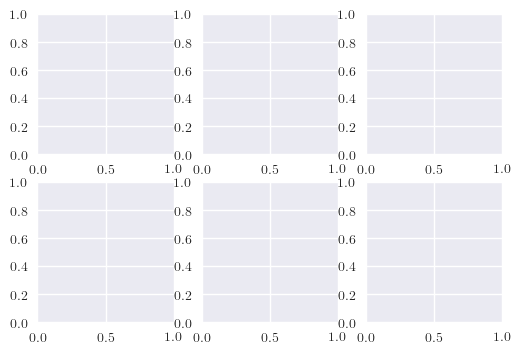

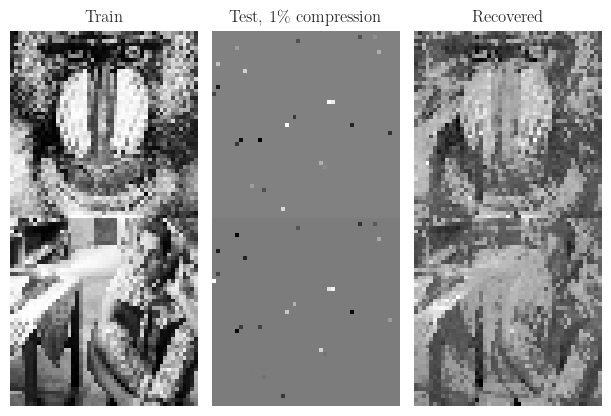

loss = 25096.677734375 
 psnr = 4.859321594238281 
 ssim = 0.0012311249738559127


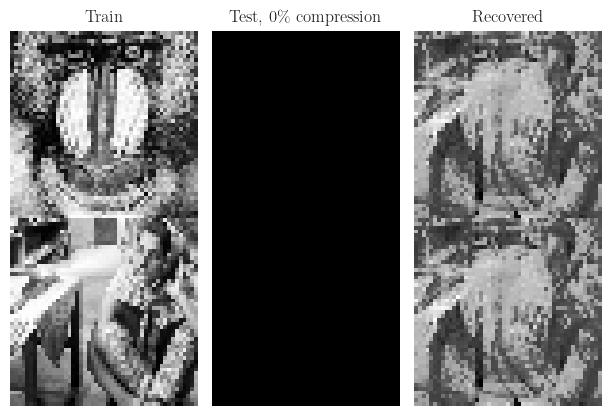

loss = 17618.408203125 
 psnr = 6.3963727951049805 
 ssim = 0.11286914348602295


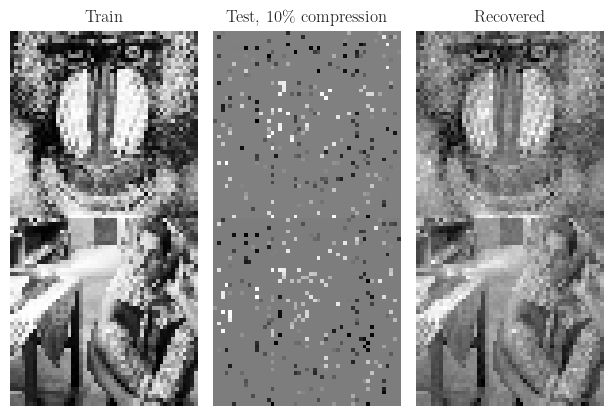

loss = 13298.66796875 
 psnr = 7.710904121398926 
 ssim = 0.2678930163383484


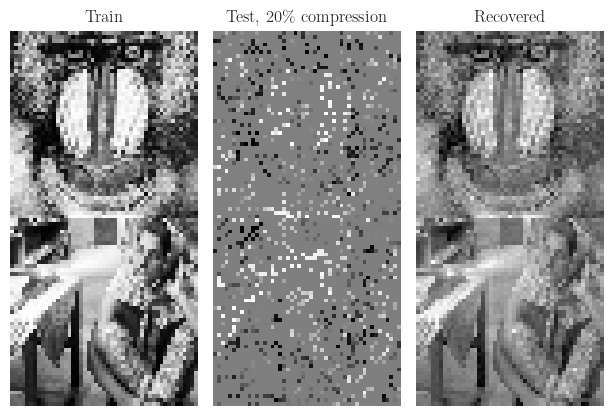

loss = 10544.974609375 
 psnr = 8.643104553222656 
 ssim = 0.37862226366996765


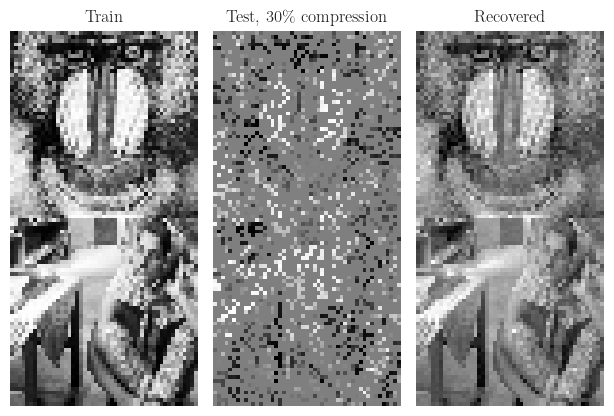

loss = 6399.7861328125 
 psnr = 10.877237319946289 
 ssim = 0.6132161617279053


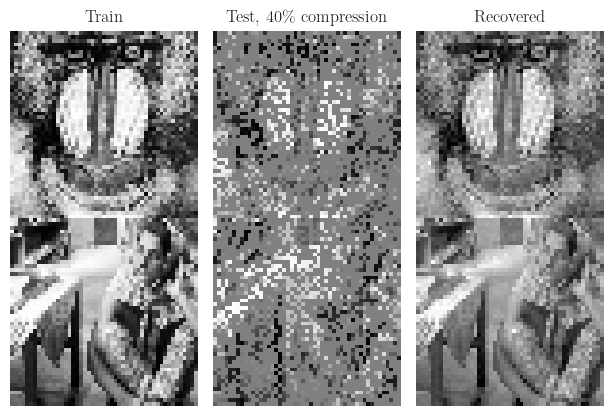

loss = 3738.88916015625 
 psnr = 13.133634567260742 
 ssim = 0.6639889478683472


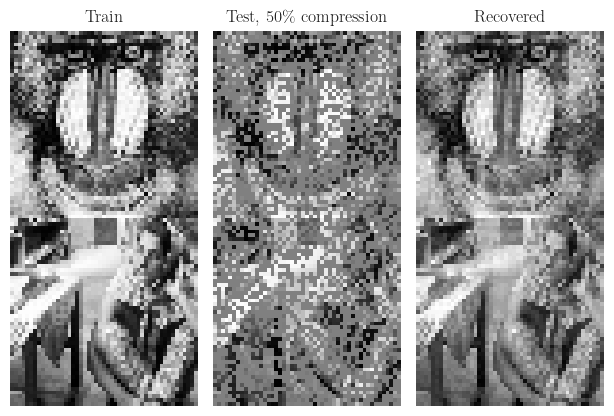

loss = 1008.672119140625 
 psnr = 18.968204498291016 
 ssim = 0.9280364513397217


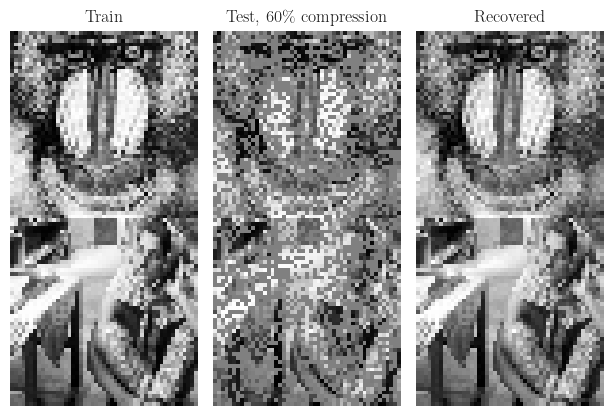

loss = 836.4046020507812 
 psnr = 19.76714324951172 
 ssim = 0.8982763290405273


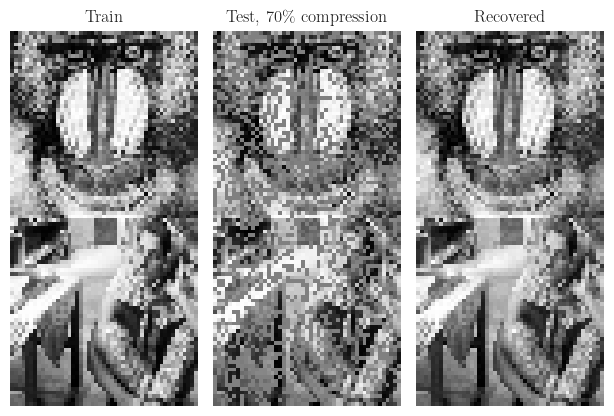

loss = 376.59478759765625 
 psnr = 23.243507385253906 
 ssim = 0.959100604057312


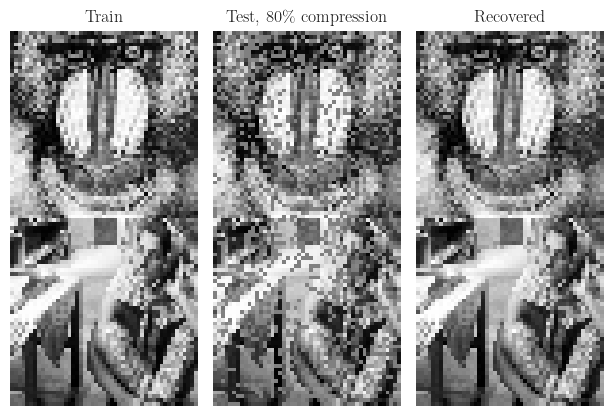

loss = 94.00945281982422 
 psnr = 29.126930236816406 
 ssim = 0.966504693031311


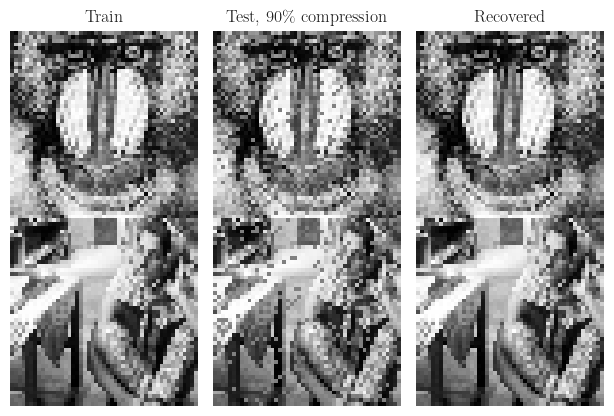

loss = 3.6247382873000333e-10 
 psnr = 143.26902770996094 
 ssim = 1.0


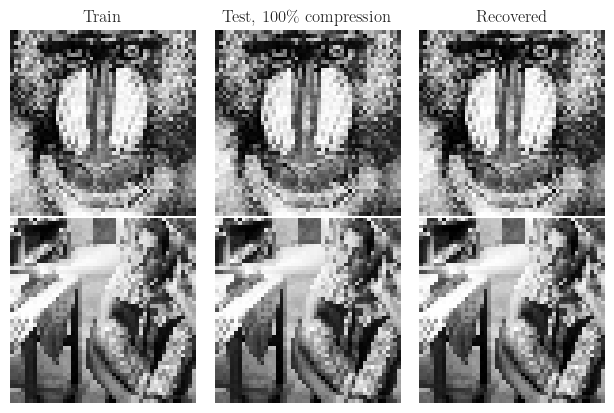

In [15]:
rand_ratio = np.concatenate(([0.01], np.arange(0.0, 1.1, 0.1)))
randpc = np.round(rand_ratio*100).astype(int)
bat_loss = np.zeros_like(randpc, float)
bat_psnr = np.zeros_like(randpc, float)
bat_ssim = np.zeros_like(randpc, float)

for j, p in enumerate(rand_ratio):
    mask = rand.choice([0, 1], size=(img_h, img_w, img_ch), p=[1-p, p])
    x_test = np.array([x_train0[i]*mask for i in range(len(x_train0))])

    rec = amrnn.predict(x_test)
    mets = amrnn.test_on_batch(x_train0, rec)
    print('loss = {} \n psnr = {} \n ssim = {}'.format(*mets))
    bat_loss[j] = mets[0]
    bat_psnr[j] = mets[1]
    bat_ssim[j] = mets[2]

    fig, ax = plt.subplots(cap, 3, figsize=(6, cap*2))
    if cap == 1:
        ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title('Test, {}\% compression'.format(int(p*100)))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

#     mp.savefig(sessiondir + '3inputs_{}pcratio.png'.format(int(p*100)),
#                dpi=300,
#                bbox_inches='tight',
#                transparent=True)
    plt.grid(False)
    plt.tight_layout(pad=0.2)
    plt.show()

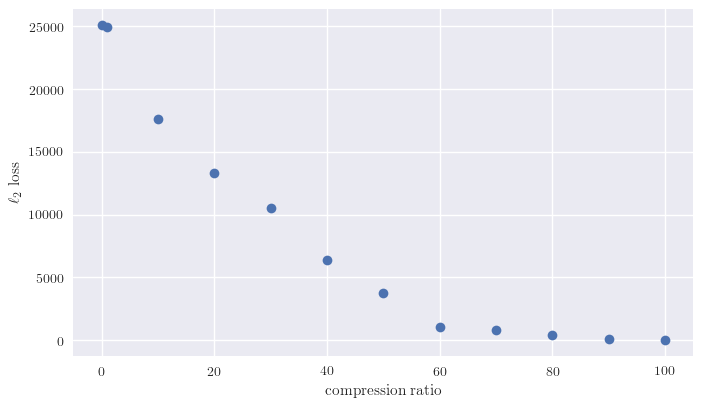

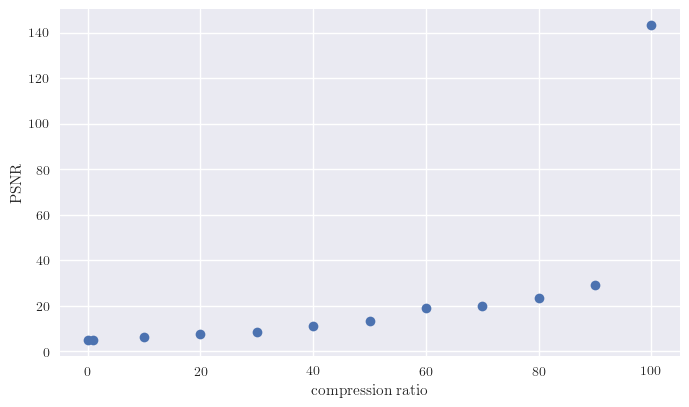

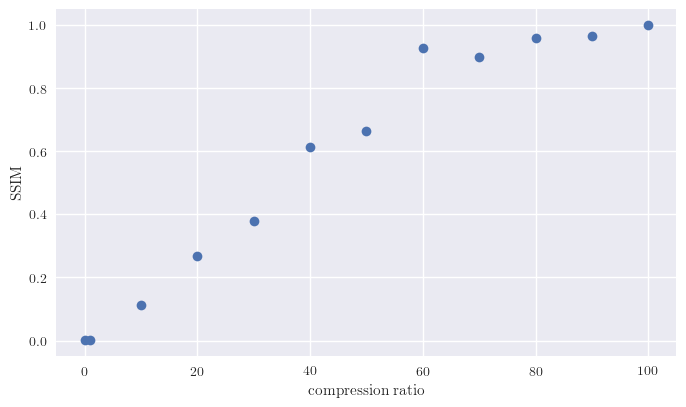

In [16]:
plt.plot(randpc, bat_loss, 'o')
plt.xlabel('compression ratio')
plt.ylabel('$\ell_2$ loss')
# plt.savefig(sessiondir + '%iinputs_batch_loss.png' %cap,
#            dpi=300, bbox_inches='tight',
#            transparent=True)
plt.show()

plt.plot(randpc, bat_psnr, 'o')
plt.xlabel('compression ratio')
plt.ylabel('PSNR')
# plt.savefig(sessiondir + '%iinputs_batch_psnr.png' %cap,
#            dpi=300, bbox_inches='tight',
#           transparent=True)
plt.show()

plt.plot(randpc, bat_ssim, 'o')
plt.xlabel('compression ratio')
plt.ylabel('SSIM')
# plt.savefig(sessiondir + '%iinputs_batch_ssim.png' %cap,
#            dpi=300, bbox_inches='tight',
#           transparent=True)
plt.show()

loss = 3.7193875757068895e-10 
 psnr = 143.15713500976562 
 ssim = 1.0


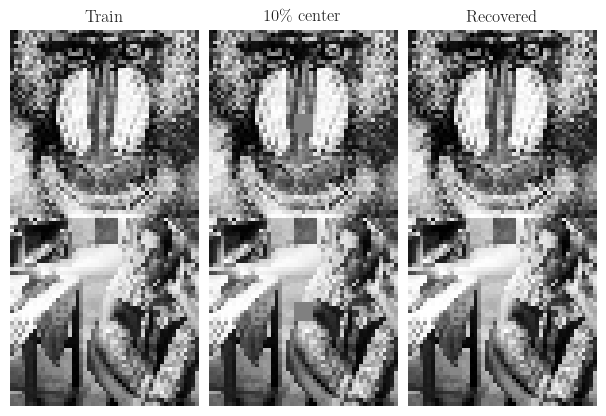

loss = 6.405764807482228e-10 
 psnr = 140.89862060546875 
 ssim = 1.0


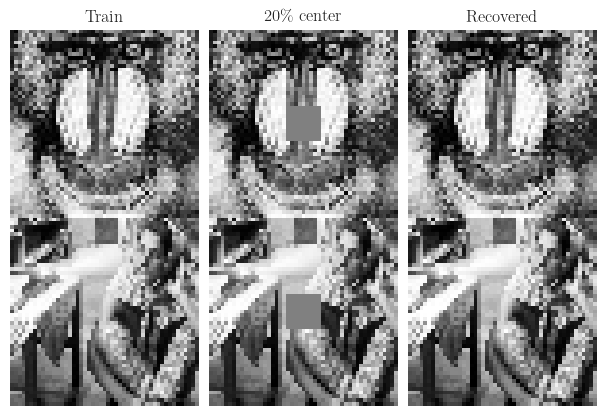

loss = 1.5854812573934396e-08 
 psnr = 126.86141967773438 
 ssim = 1.0


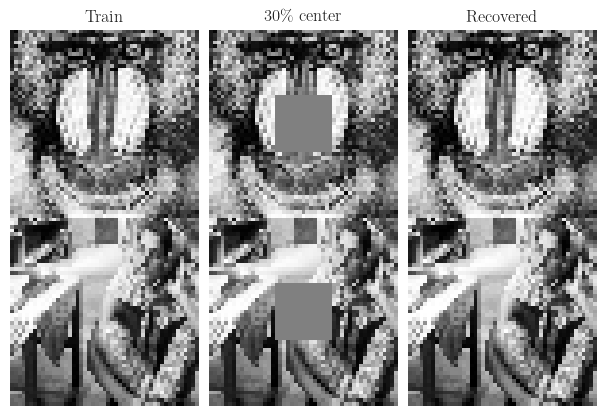

loss = 9.150960522674723e-08 
 psnr = 120.74877166748047 
 ssim = 1.0


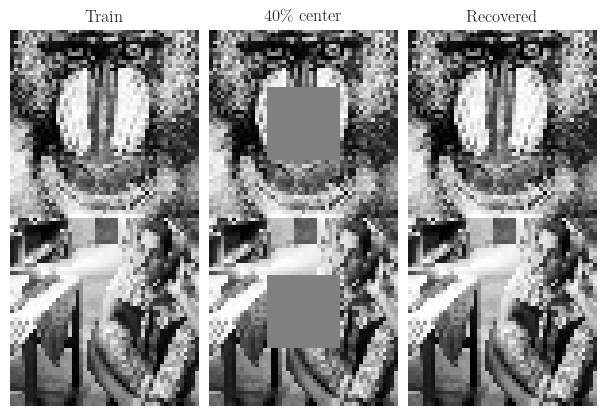

loss = 2.8829133952967823e-05 
 psnr = 94.76632690429688 
 ssim = 1.0


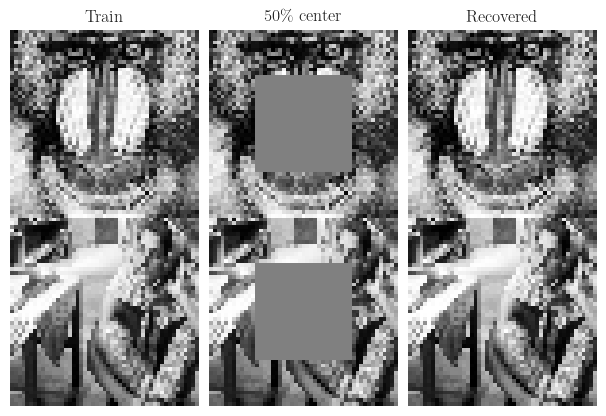

loss = 0.00044877640902996063 
 psnr = 82.45417785644531 
 ssim = 0.9999997615814209


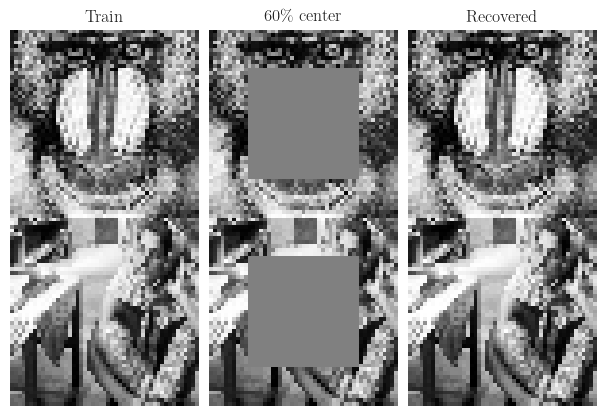

loss = 0.0465216301381588 
 psnr = 62.4327392578125 
 ssim = 0.9999513626098633


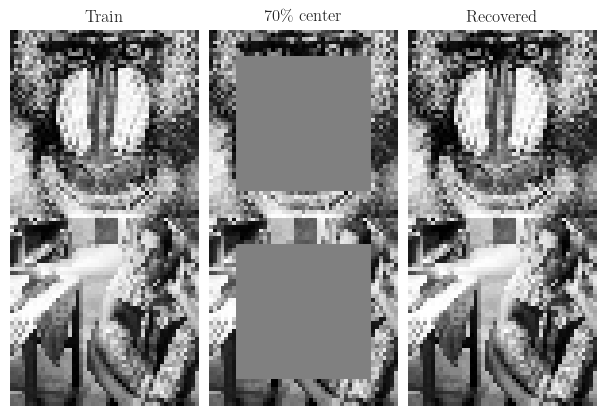

loss = 1.7574694156646729 
 psnr = 46.40666580200195 
 ssim = 0.998223066329956


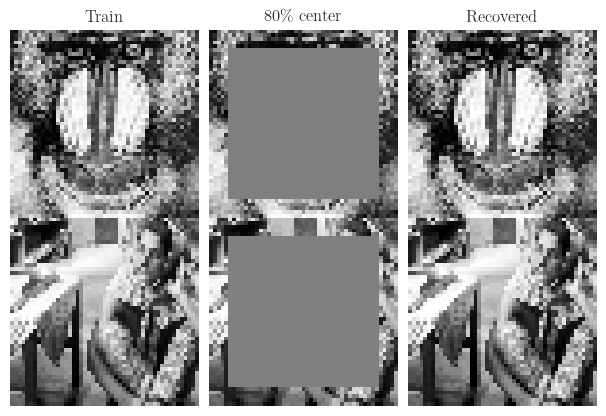

loss = 156.197509765625 
 psnr = 27.059894561767578 
 ssim = 0.966162919998169


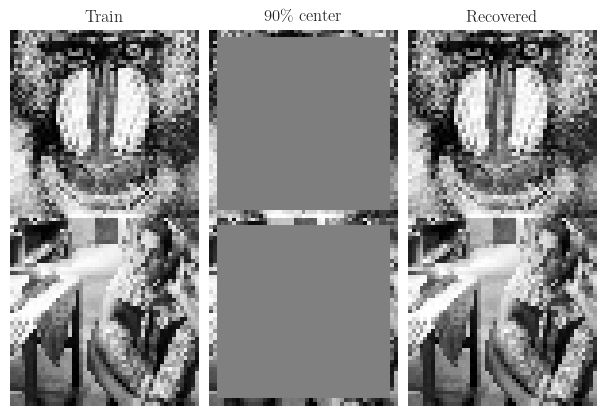

loss = 25096.677734375 
 psnr = 4.859321594238281 
 ssim = 0.0012311249738559127


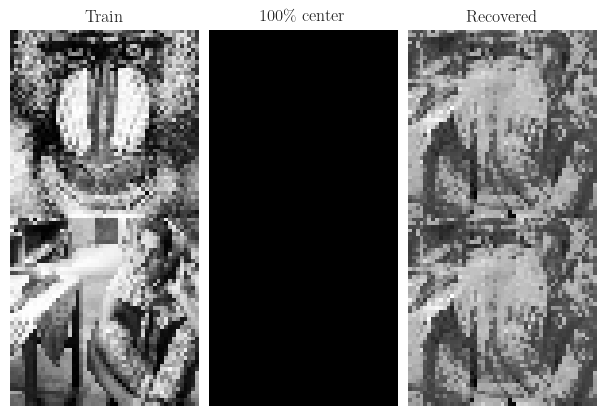

In [20]:
border_percent = np.arange(0.1, 1.1, 0.1)
borderpc = np.round(border_percent*100).astype(int)
bat_loss = np.zeros_like(border_percent)
bat_psnr = np.zeros_like(border_percent)
bat_ssim = np.zeros_like(border_percent)

for j, b in enumerate(border_percent):
    border_mask = np.ones_like(x_train0[0])
    L = len(border_mask)
    border_size = int(L*b)//2
    border_mask[L//2-border_size : L//2+border_size+1, 
                L//2-border_size : L//2+border_size+1] = 0
    
    x_test = np.array([x_train0[i]*border_mask for i in range(len(x_train0))])

    rec = amrnn.predict(x_test)
    mets = amrnn.test_on_batch(x_train0, rec)
    bat_loss[j] = mets[0]
    bat_psnr[j] = mets[1]
    bat_ssim[j] = mets[2]
    print('loss = {} \n psnr = {} \n ssim = {}'.format(*mets))

    fig, ax = plt.subplots(cap, 3, figsize=(6, cap*2))
    if cap == 1:
        ax = np.expand_dims(ax, 0)
    for i in range(cap):
        if i == 0:
            ax[i, 0].set_title('Train')
            ax[i, 1].set_title(r'{}\% center'.format(borderpc[j]))
            ax[i, 2].set_title('Recovered')
        ax[i, 0].imshow(x_train0[i,:,:,0], 'gray')
        ax[i, 0].axis('off')
        ax[i, 1].imshow(x_test[i,:,:,0], 'gray')
        ax[i, 1].axis('off')
        ax[i, 2].imshow(rec[i,:,:,0], 'gray')
        ax[i, 2].axis('off')

#     mp.savefig(sessiondir + '3inputs' + n + '.png',
#                dpi=300,
#                bbox_inches='tight',
#                transparent=True)
    plt.grid(False)
    plt.tight_layout(pad=0.2)
    plt.show()

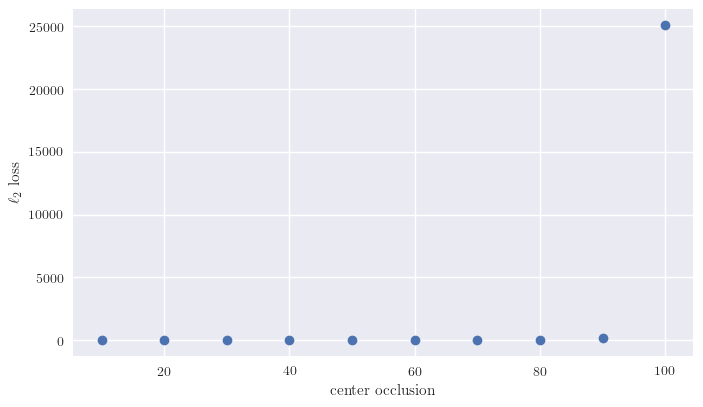

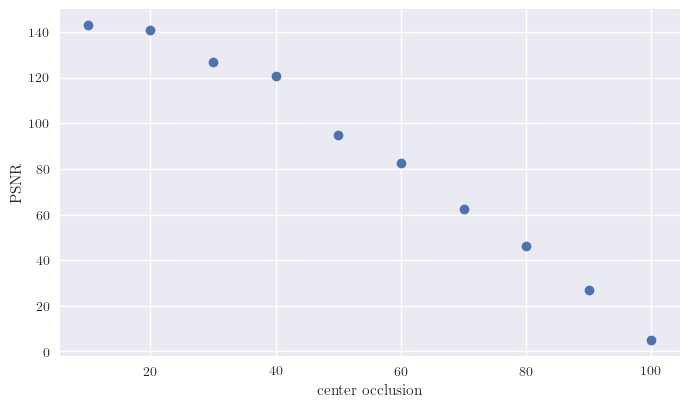

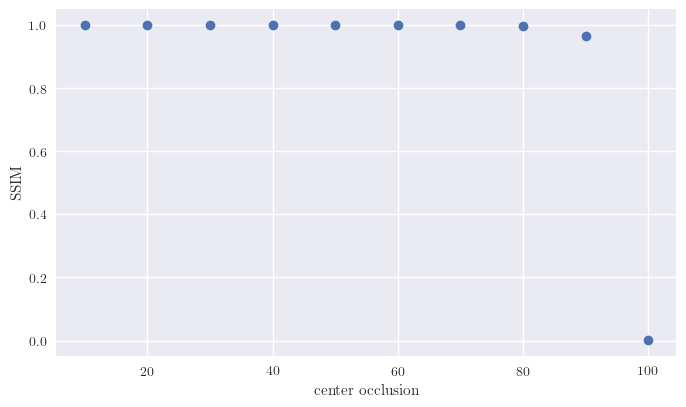

In [22]:
plt.plot(borderpc, bat_loss, 'o')
plt.xlabel('center occlusion')
plt.ylabel('$\ell_2$ loss')
# plt.savefig(sessiondir + '%iinputs_batch_loss.png' %cap,
#            dpi=300, bbox_inches='tight',
#            transparent=True)
plt.show()

plt.plot(borderpc, bat_psnr, 'o')
plt.xlabel('center occlusion')
plt.ylabel('PSNR')
# plt.savefig(sessiondir + '%iinputs_batch_psnr.png' %cap,
#            dpi=300, bbox_inches='tight',
#           transparent=True)
plt.show()

plt.plot(borderpc, bat_ssim, 'o')
plt.xlabel('center occlusion')
plt.ylabel('SSIM')
# plt.savefig(sessiondir + '%iinputs_batch_ssim.png' %cap,
#            dpi=300, bbox_inches='tight',
#           transparent=True)
plt.show()